# Application Development (GIS) -  University of Salzburg

### Final Project: Jakob Schmollgruber

Submission: 14. 5. 2018

# New York City Taxi Trip Duration

"In this competition, Kaggle is [challenging](https://www.kaggle.com/c/nyc-taxi-trip-duration) you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables." -Kaggle


In this final Project of Application Development (GIS) we want to develop and train a Machine Learning algorithm to be able to predict the approximate trip duration of a NYC Taxi. Needless to say, this prediction is not just helpful to determine driving time of taxis. 

We decided to choose an educative, well documented approach - to be sure even laymens are able to understand the core steps in this project.

## 0. Machine Learning Approach 


This trip duration prediction task can be solved by a classical Supervised Learning approach. Supervised Learning means you have labeled training data - for some cab rides you know the true trip time. With the aid of this data we want to generate a generalized model to be able to predict unknown trips. 

We picture to oneself a Machine Learning Algorithm like a mathematical function f. 
 
f ( Explanatory Variables ) = trip_duration
 
This function f we want to obtain in this FINAL Project. 

## 1. Data import & description

At first, we import the dataset and all the packages we need in this section. 

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
data_raw=pd.read_csv("train.csv")

The code in the next line shows that we are dealing with 1458644 observed taxi trips. Each trip has 11 features. 

In [2]:
data_raw.shape

(1458644, 11)

Here we can see the data type of every single feature. We suggest using this function all along - it's helpful to know what kind of data you are dealing with.

In [3]:
data_raw.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Now let's take a closer look to the dataframe:

In [4]:
display(data_raw.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## 2. First Data Vizualisation

As they say 'a picture paints a thousand words' - to understand the data best we always visualize the data we are dealing with. It helps to get a better understanding of the data.

As we can see in the histogram the 'pickup_latitude' data biased. There are such extreme values that we expect the data to be false or at least irrelevant for our prediction. We can recognize the same property in all gps data features. We will drop these observation.

Text(0,0.5,'density')

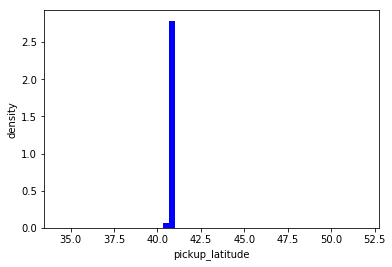

In [38]:
import matplotlib.pyplot as plt
n, bins, patches =plt.hist(data_raw['pickup_latitude'], 50, density=1, facecolor='b', alpha=1)
plt.xlabel('pickup_latitude')
plt.ylabel('density')

We see even 'trip_duration', the response variable is contaminated by outliners:

Text(0,0.5,'density')

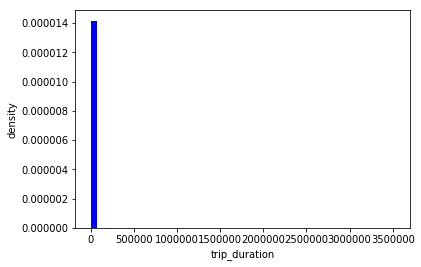

In [32]:
n, bins, patches =plt.hist(data_raw['trip_duration'], 50, density=1, facecolor='b', alpha=1)
plt.xlabel('trip_duration')
plt.ylabel('density')

 We need to clean the input data. This leads to this:

## 3. Data Preprocessing

In the following section we will clean the data. This means we will drop observation with extreme values. We assume that there occurred some errors in the measurement process - at least this data would not behave well to the success of our predictor.

In addition, all the time data is stored in date objects - we have to extract this and save to atomar features. 
This procedure is necessary - the original data is not suitable for Machine Learning algorithms.

### 3.1. Extracting Data

In [33]:
import datetime

In [8]:
def split_date(string):
    sp=string.split()
    year,month,day=sp[0].split('-')
    hour,minute,second=sp[1].split(':')
    return year,month,day,hour,minute,second

#We drop year and second
def split_date_red(string):
    sp=string.split()
    year,month,day=sp[0].split('-')
    hour,minute,second=sp[1].split(':')
    weekday=dt.date(int(year), int(month), int(day)).weekday()
    return int(month),int(day),weekday,int(hour),int(minute)

We think the year and the second do not influence the trip duration. On the other hand it's important to keep the month to consider characteristic climatic occurrences and in addition the weekday. We obtain the weekday by the datetime package. Since we have pickup and dropoff date it's reasonable to simplifying assume that day, weekday and month will be the same, so we just keep the pickup data.

<!---
Monday is 0 and Sunday is 6
-->

In [34]:
new_month=[]
new_day=[]
new_weekday=[]
new_hour=[]
new_minute=[]

for date in data_raw['pickup_datetime']:
    split_date=split_date_red(date)
    new_month.append(split_date[0])
    new_day.append(split_date[1])
    new_weekday.append(split_date[2])
    new_hour.append(split_date[3])
    new_minute.append(split_date[4])
    
processed_data= data_raw
processed_data['month']= new_month
processed_data['day']= new_day
processed_data['weekday']=new_weekday
processed_data['hour_pickup']=new_hour
processed_data['minute_pickup']=new_minute
    
    
new_hour=[]
new_minute=[]

for date in data_raw['dropoff_datetime']:
    split_date=split_date_red(date)
    new_hour.append(split_date[3])
    new_minute.append(split_date[4])
processed_data['hour_dropoff']=new_hour
processed_data['minute_dropoff']=new_minute

In [10]:
processed_data=processed_data.drop(['id', 'vendor_id','pickup_datetime','dropoff_datetime','store_and_fwd_flag'], axis=1)

### 3.2. Cleaning Explanatory Variables

In [11]:
processed_data=processed_data[processed_data['pickup_longitude'] >= -74.1]
processed_data=processed_data[processed_data['pickup_longitude'] <= -73.8]

processed_data=processed_data[processed_data['dropoff_longitude'] >= -74.1]
processed_data=processed_data[processed_data['dropoff_longitude'] <= -73.8]

In [12]:
processed_data=processed_data[processed_data['pickup_latitude'] >= 40.6]
processed_data=processed_data[processed_data['pickup_latitude'] <= 40.9]

processed_data=processed_data[processed_data['dropoff_latitude'] >= 40.6]
processed_data=processed_data[processed_data['dropoff_latitude'] <= 41.9]

### 3.3. Cleaning Response Variable 

Since the trip duration is what we are interested in, this feature is very important to us. The response variable need some particular effort of tidying. We do not want just to drop defective data, we do want to clear rows with rare values in 'trip_duration'. 
We do this because we want to train a classifier being able to predict the duration of a common taxi tour - we are not interested in party tours etc.

We decided to keep values in between the 5 % and 95 % quantile. 

In [13]:
processed_data['trip_duration'].quantile([0.05,0.5,0.95])

0.05     179.0
0.50     644.0
0.95    1854.0
Name: trip_duration, dtype: float64

In [14]:
min_trip=180
max_trip=2104

In [15]:
processed_data=processed_data[processed_data['trip_duration'] >= min_trip]
processed_data=processed_data[processed_data['trip_duration'] <= max_trip]

## 4. Data Visualization

In the past section we managed to clean and extract the data now we can generate some nice visualizations.

We will start with a histogram of the trip duration:

Text(0,0.5,'density')

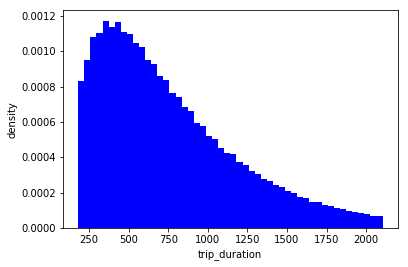

In [16]:
n, bins, patches =plt.hist(processed_data['trip_duration'], 50, density=1, facecolor='b', alpha=1)
plt.xlabel('trip_duration')
plt.ylabel('density')

The 25 %, 50 % and 75 quantile of the 'trip_duration' :

In [17]:
processed_data['trip_duration'].quantile([0.25,0.5,0.75])

0.25     418.0
0.50     655.0
0.75    1002.0
Name: trip_duration, dtype: float64

The mean value of 'trip_duration' :

In [18]:
processed_data['trip_duration'].mean()

755.3477881169633

Here we can see the histogram of the pickup_latitude:

Text(0,0.5,'density')

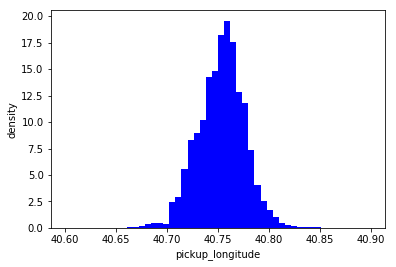

In [19]:
n, bins, patches =plt.hist(processed_data['pickup_latitude'], 50, density=1, facecolor='b', alpha=1)
plt.xlabel('pickup_longitude')
plt.ylabel('density')

The next one is a bit more technical. Visualization like that are called confusion plots. 
In a multi feature dataset they help to illustrate properties between two features. In our case we used the confusion plot to visualize the pairwise correlation coefficient of columns: 

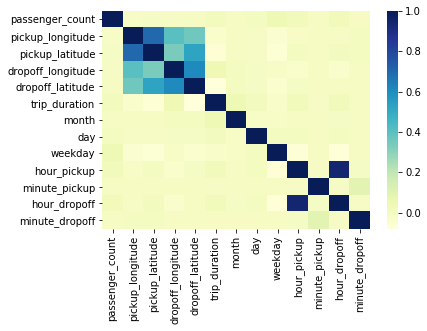

In [20]:
import seaborn as sns
ax = sns.heatmap(processed_data.corr(method='spearman'),cmap="YlGnBu")

On the diagonal there we have a correlation coefficient of 1 for sure. We can see that pickup laltitude and drop off laltitude are correlating - which seems reasonable.

In the next picture we can see a boxplot of the trip_duration depending on the time of day. 
We can see this feature will have some large influence on the trip_duration.

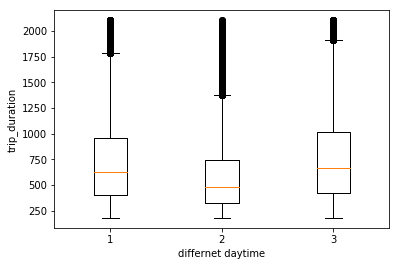

In [21]:
pr1=processed_data[processed_data['hour_pickup'] == 1]
pr2=processed_data[processed_data['hour_pickup'] == 6]
pr3=processed_data[processed_data['hour_pickup'] == 16]

data=[pr1['trip_duration'],pr2['trip_duration'],pr3['trip_duration']]
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.set_xlabel('differnet daytime')
ax.set_ylabel('trip_duration')
a=ax.boxplot(data)

## 5. Feature Transformation & Pre- knowledge

The haversine function returns the airline distance of a taxi trip calculated based on the gps coordinates. 

https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

In [22]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

We apply this function on the gps coordinates in the processed_data dataset and generate the distance new column. 

This feature helps the Machine Learning Algorithm to understand the distance property  of the pickup and dropoff coordinates.
Approaches likes this we call pre- knowledge retrieval.

In [23]:
processed_data['distance'] = processed_data.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'],row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

The domain's range of the features in our dataset varies a lot. This has a bad influence on all not translation invariant Machine Learning algorithms. We do not want to explain this process more in detail.
As a matter of fact we do want to have all values of all feature in [0,1].

In [24]:
processed_data['month']=processed_data['month']/12
processed_data['day']=processed_data['day']/31
processed_data['weekday']=processed_data['weekday']/6
processed_data['hour_pickup']=processed_data['hour_pickup']/24
processed_data['hour_dropoff']=processed_data['hour_dropoff']/24
processed_data['pickup_longitude']=processed_data['pickup_longitude']/(-74.1)
processed_data['dropoff_longitude']=processed_data['dropoff_longitude']/(-74.1)

processed_data['pickup_latitude']=processed_data['pickup_latitude']/41.9
processed_data['dropoff_latitude']=processed_data['dropoff_latitude']/41.9
processed_data['minute_dropoff']=processed_data['minute_dropoff']/60
processed_data['minute_pickup']=processed_data['minute_pickup']/60
processed_data['distance']=processed_data['distance']/processed_data['distance'].max()

We display the pre- processed data:

In [25]:
display(processed_data.head())

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month,day,weekday,hour_pickup,minute_pickup,hour_dropoff,minute_dropoff,distance
0,1,0.998410,0.972982,0.998173,0.972926,455,0.250000,0.451613,0.000000,0.708333,0.400000,0.708333,0.533333,0.045233
1,1,0.998386,0.972281,0.998643,0.972104,663,0.500000,0.387097,1.000000,0.000000,0.716667,0.000000,0.900000,0.054500
3,1,0.998786,0.971837,0.998816,0.971521,429,0.333333,0.193548,0.333333,0.791667,0.533333,0.791667,0.650000,0.044840
4,1,0.998287,0.973585,0.998285,0.973330,435,0.250000,0.838710,0.833333,0.541667,0.500000,0.541667,0.633333,0.035878
5,6,0.998419,0.972367,0.998544,0.972534,443,0.083333,0.967742,0.833333,0.916667,0.016667,0.916667,0.150000,0.033172


Let's look at the data types again:

In [26]:
processed_data.dtypes

passenger_count        int64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_duration          int64
month                float64
day                  float64
weekday              float64
hour_pickup          float64
minute_pickup        float64
hour_dropoff         float64
minute_dropoff       float64
distance             float64
dtype: object

We can see there are no object types in the dataframe anymore.

Now we drop all the features we do not need anymore (as a matter of the new cleaned data). 

In [27]:
processed_data2=processed_data.drop(['passenger_count','month','day','weekday','hour_pickup','hour_dropoff','minute_dropoff','minute_pickup'], axis=1)

## 6. Train-Test- Split
We finished the data pre- processing. Now we can split into training and test data to be able to see how our predictor is working on unseen data. This is necessary to be able to compare the quality of the predictor. We choose 'random_state=42' to warrant reproducibility.

In [28]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

data_X=processed_data.drop(['trip_duration'],axis=1)
data_y=processed_data[['trip_duration']]
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.20, random_state=42)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 7. Train Machine Learning Algorithm

## 7.1. Random Forest Regressor

Now the time is up to train our actual predictor. We decided to use a random forest as predictor. A nice video explaining RF https://www.youtube.com/watch?v=D_2LkhMJcfY.

In [29]:
from sklearn.ensemble import RandomForestRegressor
cls1=RandomForestRegressor(n_estimators=15)
cls1.fit(X_train, y_train)
y_pred=cls1.predict(X_test)

## 8. Evaluate 

Now we use the test data (true trip_duration) and our predicted duration to evaluate our Machine Learning Algorithm.

In [30]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test,y_pred)

103.86666666666667

In [31]:
y_true=np.array(y_test['trip_duration'])
pd.DataFrame(abs(y_pred-y_true)).describe()

,0
count,259015.000000
mean,142.767118
std,138.696911
min,0.000000
25%,47.133333
50%,103.866667
75%,193.666667
max,1707.000000


Some space above we saw that the median trip takes 655.0 seconds. As we can see the median error supplied by the predictor is 103.8 seconds. So is this a good result?

Let's remember the last times in traffic. Sometimes the traffic is moving - sometime it isn't.
It seems that there does not exist a perfect predictor - there are to many dependencies we do not know and of course we do not have all sufficient data. So there is a huge variance in trip duration for similar cab rides.

As a matter of fact we think a median error of 103.8 seconds is quite a nice result we can be proud of a bit. 